<a href="https://colab.research.google.com/github/Harish-topper12/Deep_Learning_Assignment/blob/main/CNN_Assignment2_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -----------------------------
# Importing required TensorFlow and Keras packages

# TensorFlow-specific imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# Base Keras imports
import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential

# For model optimization, training strategies, and callbacks
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Layers specific to convolutional neural networks (CNNs)
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout

# For image data augmentation and preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Additional utility and visualization imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Dataset-specific imports
from keras.datasets import cifar10

# For splitting and handling data
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# -----------------------------


In [2]:
# Displaying the installed version of TensorFlow
print(tf.__version__)

# Displaying the installed version of Keras
print(keras.__version__)

2.14.0
2.14.0


### Loading and Splitting CIFAR-10 dataset

In [3]:
# Loading the CIFAR-10 dataset into training and test sets
(x_train_val, y_train_val), (x_test, y_test) = cifar10.load_data()

# Splitting the original training data into training and validation sets
# Using stratification to ensure that the validation set has the same class distribution as the original training set
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2, random_state = 42, stratify = y_train_val)

170498071/170498071 [==============================] - 13s 0us/step


In [4]:
# Displaying the shape of the training dataset (number of samples and image dimensions)
print(f"Training set shape: {x_train.shape}")

# Displaying the shape of the validation dataset (number of samples and image dimensions)
print(f"Validation set shape: {x_val.shape}")

# Displaying the shape of the test dataset (number of samples and image dimensions)
print(f"Test set shape: {x_test.shape}")


Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


#### Displaying Random Images from trained dataset

In [5]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

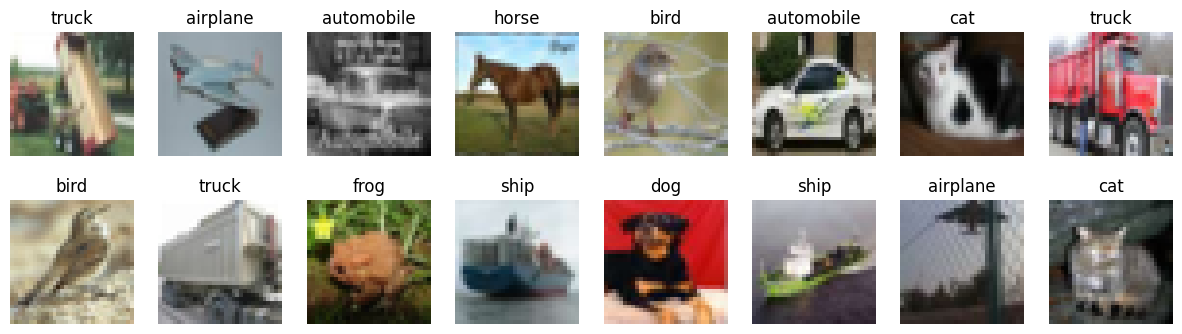

In [6]:
# Show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

### One - Hot Encoding on target values

In [7]:
# Converting the training labels to one-hot encoded vectors
y_train = to_categorical(y_train)

# Converting the test labels to one-hot encoded vectors
y_test = to_categorical(y_test)

# Converting the validation labels to one-hot encoded vectors
y_val = to_categorical(y_val)

In [8]:
# Verifying the one-hot encoding of the training labels
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Normalizing Scaled Data

In [9]:
# Converting the training data to float type and normalizing it to the range [0, 1]
x_train = x_train.astype('float32')
x_train = x_train/255.0

# Converting the validation data to float type and normalizing it to the range [0, 1]
x_val = x_val.astype('float32')
x_val = x_val/255.0

# Converting the test data to float type and normalizing it to the range [0, 1]
x_test = x_test.astype('float32')
x_test = x_test/255.0

### Model Diagnostics & Insights

In [40]:
def summarize_diagnostics(history):
    """
    Visualizes the training history: plots the training and validation loss and accuracy.

    Parameters:
    - history : Training history object generated by the `fit` method of a Keras model.

    Returns:
    - None. Displays the plot.
    """

    # Set up a 2x1 grid of subplots
    plt.figure(figsize=(10, 6))  # You can adjust this for better visualization as needed

    # ----------------
    # Plotting the loss over epochs
    # ----------------

    plt.subplot(211)  # The top subplot for loss visualization

    # Setting title and plotting the training and validation loss
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='Train')
    plt.plot(history.history['val_loss'], color='orange', label='Validation')

    # Adding x and y axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Displaying the legend to differentiate between training and validation loss
    plt.legend(loc='upper right')

    # ----------------
    # Plotting the accuracy over epochs
    # ----------------

    plt.subplot(212)  # The bottom subplot for accuracy visualization

    # Setting title and plotting the training and validation accuracy
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='Train')
    plt.plot(history.history['val_accuracy'], color='orange', label='Validation')

    # Adding x and y axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Displaying the legend to differentiate between training and validation accuracy
    plt.legend(loc='upper left')

    # Adjusting the layout to ensure non-overlapping
    plt.tight_layout()

    # Show the plots
    plt.show()

In [11]:
def top3_class_accuracies(model,x_test = x_test, test_labels = y_test):
    # Load CIFAR-10 data

    test_labels = np.argmax(test_labels, axis=1)

    test_labels = test_labels.squeeze()  # Remove single-dimensional entries



    # Get model predictions for the test set
    predicted_classes = np.argmax(model.predict(x_test), axis=1)

    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Calculate accuracy for each class
    class_accuracies = {}
    for i, class_name in enumerate(class_names):
        correct_predictions = np.sum((test_labels == i) & (predicted_classes == i))
        total = np.sum(test_labels == i)
        class_accuracies[class_name] = correct_predictions / total

    # Sort and select top 3 classes
    sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)[:3]

    return sorted_accuracies

In [12]:
def plot_top3_accuracies(model, arch_name):
    """
    Plots the top 3 class accuracies for a given model and architecture name.

    Parameters:
    - model : Trained Keras model to evaluate.
    - arch_name : String representing the architecture or model name, for display purposes.

    Returns:
    - None. Displays a bar plot of the top 3 class accuracies.
    """

    # Use the previously defined function to get the top 3 class accuracies for the given model
    top3_accuracies = top3_class_accuracies(model, x_test=x_test, test_labels=y_test)

    # Print the top 3 class accuracies for reference
    print(top3_accuracies)

    # Extract class names and their corresponding accuracies from the result for plotting
    classes, accuracies = zip(*top3_accuracies)

    # Set up the bar plot for the top 3 class accuracies
    bars = plt.bar(classes, accuracies, color=['blue', 'green', 'red'])
    plt.xlabel('Classes')         # Label for the x-axis
    plt.ylabel('Accuracy')        # Label for the y-axis
    plt.title(f'Top 3 Class Accuracies for {arch_name}')  # Title for the plot, using the provided architecture name
    plt.ylim(0, 1)                # Set the y-axis limits to [0, 1] to represent accuracy range
    plt.tight_layout()           # Adjust the layout to ensure non-overlapping of elements

    # Display the plot
    plt.show()

In [13]:
import matplotlib.pyplot as plt

def plot_top_3_misclassifications(results):
    """
    Plot a bar chart showing the top 3 misclassifications.

    Parameters:
    - results (list of tuples): Each tuple contains two misclassified class names and the count of misclassifications.
    """
    # Extract class pairs and counts
    class_pairs = [f"{res[0]} -> {res[1]}" for res in results]
    counts = [res[2] for res in results]

    plt.figure(figsize=(10, 5))
    plt.bar(class_pairs, counts, color=['red', 'blue', 'green'])
    plt.xlabel('Misclassified Class Pairs')
    plt.ylabel('Count')
    plt.title('Top 3 Misclassified Classes')
    plt.show()




#### VGG-inspired Baseline Model

In [14]:
def vgg_based_cifar10_baseline_model():
    """
    Construct a VGG-inspired model for CIFAR-10 classification.

    Returns:
    - A compiled Keras model suitable for the CIFAR-10 dataset.
    """
    model = Sequential()

    # Block 1: Two convolutional layers followed by max-pooling
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 2: Two convolutional layers followed by max-pooling with increased filters
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 3: Two convolutional layers followed by max-pooling with even more filters
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers: Flattening followed by dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

    # Compile the model using SGD optimizer and categorical cross-entropy loss
    optimizer = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
vgg_cifar10_baseline_model = vgg_based_cifar10_baseline_model()
vgg_history = vgg_cifar10_baseline_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks = [early_stopping])

Epoch 1/50
1250/1250 [==============================] - 18s 6ms/step - loss: 1.6843 - accuracy: 0.3893 - val_loss: 1.4037 - val_accuracy: 0.4910
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3137 - accuracy: 0.5275 - val_loss: 1.2244 - val_accuracy: 0.5651
Epoch 3/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1116 - accuracy: 0.6050 - val_loss: 1.1088 - val_accuracy: 0.6099
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9768 - accuracy: 0.6565 - val_loss: 1.0322 - val_accuracy: 0.6364
Epoch 5/50
1250/1250 [==============================] - 7s 5ms/step - loss: 0.8649 - accuracy: 0.6970 - val_loss: 0.9619 - val_accuracy: 0.6690
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7686 - accuracy: 0.7304 - val_loss: 0.9015 - val_accuracy: 0.6786
Epoch 7/50
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6860 - accuracy: 0.7609 - val_loss: 0.9011 - val_accuracy

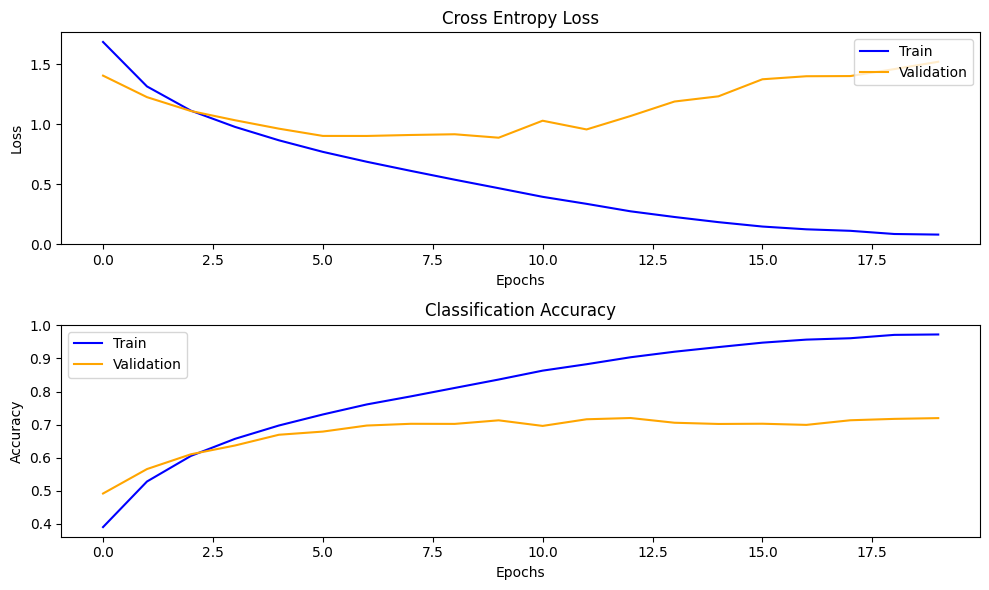

In [41]:
summarize_diagnostics(vgg_history)

In [17]:
baseline_vgg_train_loss, baseline_vgg_train_accuracy = vgg_cifar10_baseline_model.evaluate(x_train, y_train)
baseline_vgg_train_accuracy

1250/1250 [==============================] - 4s 3ms/step - loss: 0.3604 - accuracy: 0.8798


0.8797749876976013

In [18]:
baseline_vgg_val_loss, baseline_vgg_val_accuracy = vgg_cifar10_baseline_model.evaluate(x_val, y_val)
baseline_vgg_val_accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.8865 - accuracy: 0.7127


0.7127000093460083

In [19]:
baseline_vgg_test_loss, baseline_vgg_test_accuracy = vgg_cifar10_baseline_model.evaluate(x_test, y_test)
baseline_vgg_test_accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.8918 - accuracy: 0.7112


0.7111999988555908

### Insights from the Graph of the Baseline Model:

**Based on the visual data:**

1. We notice a steady rise in training accuracy, yet the test accuracy seems to stagnate. This indicates that our model might be becoming too tailored to the training dataset and struggles to adapt to unfamiliar data, leading to overfitting.

2. The test set's Cross Entropy Loss is significantly elevated, with a clear distinction between the losses observed during training and testing.

**Considering these insights, strategies for model enhancement include:**

i) To address the generalization issue, we aim to integrate data augmentation and regularization strategies like dropout.

ii) To potentially boost test accuracy, we're considering adding another VGG block.

iii) Incorporating Batch Normalization might stabilize the deep network's training by ensuring a more uniform distribution for each layer's inputs.

#### Enhanced VGG with Data Augmentation

In [20]:
def vgg_augmented():
    """
    This function defines a VGG-inspired architecture for CIFAR-10 classification.
    This model has two additional VGG blocks compared to the baseline, making it deeper.
    The design is intended to be used in combination with data augmentation techniques
    to improve generalization over the dataset.
    """
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 4 - New Block
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes

    optimizer = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [21]:
vgg_augmented_model = vgg_augmented()

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.,
    zoom_range=0.,
    vertical_flip=False,
    fill_mode='nearest',
    cval=0.,
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    data_format=None
)

# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=32)
# fit model
steps = int(x_train.shape[0] / 32)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

vgg_augmented_history = vgg_augmented_model.fit(it_train, steps_per_epoch=steps, epochs=100, validation_data=(x_val, y_val), callbacks = [early_stopping])

Epoch 1/100
1250/1250 [==============================] - 25s 18ms/step - loss: 1.7628 - accuracy: 0.3536 - val_loss: 1.4129 - val_accuracy: 0.4849
Epoch 2/100
1250/1250 [==============================] - 22s 18ms/step - loss: 1.4296 - accuracy: 0.4813 - val_loss: 1.4130 - val_accuracy: 0.5010
Epoch 3/100
1250/1250 [==============================] - 22s 18ms/step - loss: 1.2915 - accuracy: 0.5353 - val_loss: 1.1367 - val_accuracy: 0.6044
Epoch 4/100
1250/1250 [==============================] - 22s 18ms/step - loss: 1.1746 - accuracy: 0.5813 - val_loss: 1.0893 - val_accuracy: 0.6141
Epoch 5/100
1250/1250 [==============================] - 22s 18ms/step - loss: 1.0760 - accuracy: 0.6157 - val_loss: 0.9488 - val_accuracy: 0.6673
Epoch 6/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.0034 - accuracy: 0.6476 - val_loss: 0.9790 - val_accuracy: 0.6578
Epoch 7/100
1250/1250 [==============================] - 23s 19ms/step - loss: 0.9443 - accuracy: 0.6654 - val_loss: 0

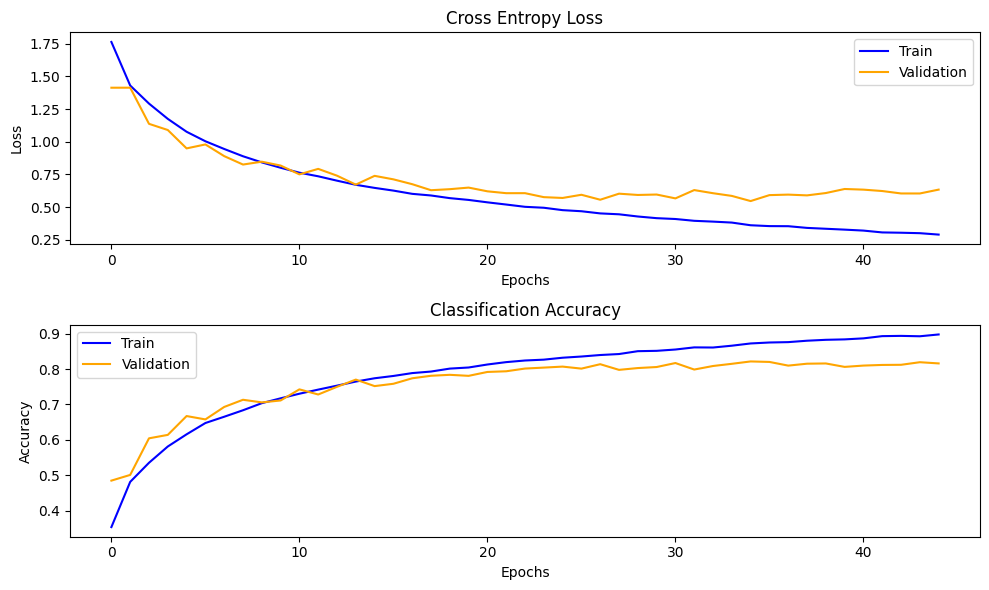

In [42]:
summarize_diagnostics(vgg_augmented_history)

In [23]:
vgg_augmented_train_loss, vgg_augmented_train_accuracy = vgg_augmented_model.evaluate(x_train, y_train)
vgg_augmented_train_accuracy

1250/1250 [==============================] - 4s 3ms/step - loss: 0.2253 - accuracy: 0.9202


0.9202499985694885

In [24]:
vgg_augmented_val_loss, vgg_augmented_val_accuracy = vgg_augmented_model.evaluate(x_val, y_val)
vgg_augmented_val_accuracy

313/313 [==============================] - 1s 4ms/step - loss: 0.6335 - accuracy: 0.8160


0.8159999847412109

In [25]:
vgg_augmented_test_loss, vgg_augmented_test_accuracy = vgg_augmented_model.evaluate(x_test, y_test)
vgg_augmented_test_accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.6479 - accuracy: 0.8134


0.8133999705314636

#### Insights from the graph of enhanced VGG with Data Augmentation Model

1. Compared to the baseline model, the validation and test accuracy have improved by over 8%. Additionally, the reduced gap between training and validation/test accuracy indicates a decrease in overfitting compared to the baseline model.

2. Despite these improvements, the accuracy is still not satisfactory, and there's room to further mitigate overfitting. To address this, we plan to introduce batch normalization to each VGG block of this model to boost accuracy. Furthermore, we will incorporate dropout in conjunction with batch normalization to further curb overfitting.

#### Enhanced VGG with Drop out, Batch Normalization and Data Augmentation

In [26]:
def vgg_with_dropout_and_batch_normalization_model():
    """
    Defines a VGG-inspired architecture with dropout and batch normalization layers.

    This function creates a convolutional neural network based on the VGG architecture,
    modified for the CIFAR-10 dataset. It incorporates batch normalization after each
    convolutional layer for stable and accelerated training. Additionally, dropout layers
    are added after max-pooling operations for regularizing the model and preventing overfitting.

    Returns:
        model (Sequential): The constructed Keras Sequential model.
    """

    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Block 4 - Enhanced Block
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

    optimizer = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [27]:
vgg_dropout_batch_normalization_model = vgg_with_dropout_and_batch_normalization_model()
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=64)
# fit model
steps = int(x_train.shape[0] / 64)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

vgg_dropout_batch_normalization_history = vgg_dropout_batch_normalization_model.fit(it_train, steps_per_epoch=steps, epochs=100, validation_data=(x_val, y_val), callbacks = [early_stopping])

Epoch 1/100
625/625 [==============================] - 26s 35ms/step - loss: 1.9724 - accuracy: 0.2888 - val_loss: 1.6304 - val_accuracy: 0.3980
Epoch 2/100
625/625 [==============================] - 21s 34ms/step - loss: 1.6241 - accuracy: 0.3919 - val_loss: 1.5318 - val_accuracy: 0.4457
Epoch 3/100
625/625 [==============================] - 21s 33ms/step - loss: 1.5094 - accuracy: 0.4444 - val_loss: 1.7908 - val_accuracy: 0.3989
Epoch 4/100
625/625 [==============================] - 21s 33ms/step - loss: 1.4221 - accuracy: 0.4771 - val_loss: 1.3750 - val_accuracy: 0.5080
Epoch 5/100
625/625 [==============================] - 21s 33ms/step - loss: 1.3588 - accuracy: 0.5029 - val_loss: 1.3605 - val_accuracy: 0.5283
Epoch 6/100
625/625 [==============================] - 21s 33ms/step - loss: 1.3004 - accuracy: 0.5282 - val_loss: 1.3055 - val_accuracy: 0.5314
Epoch 7/100
625/625 [==============================] - 21s 33ms/step - loss: 1.2555 - accuracy: 0.5442 - val_loss: 1.2569 - val_ac

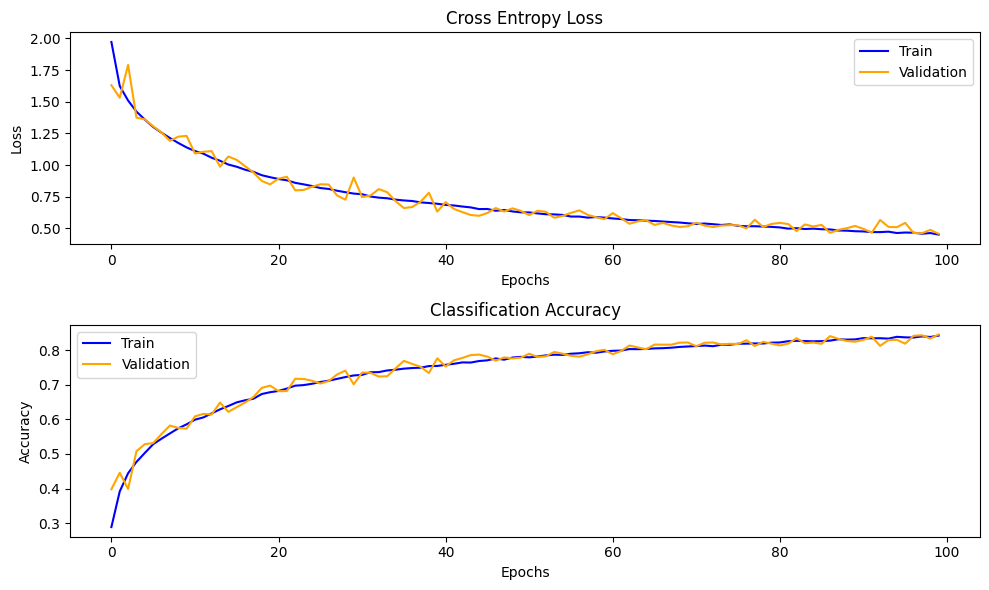

In [43]:
summarize_diagnostics(vgg_dropout_batch_normalization_history)

In [29]:
vgg_dropout_batch_normalization_train_loss, vgg_dropout_batch_normalization_train_accuracy = vgg_dropout_batch_normalization_model.evaluate(x_train, y_train)
vgg_dropout_batch_normalization_train_accuracy

1250/1250 [==============================] - 5s 4ms/step - loss: 0.3237 - accuracy: 0.8861


0.8860750198364258

In [30]:
vgg_dropout_batch_normalization_val_loss, vgg_dropout_batch_normalization_val_accuracy = vgg_dropout_batch_normalization_model.evaluate(x_val, y_val)
vgg_dropout_batch_normalization_val_accuracy

313/313 [==============================] - 1s 4ms/step - loss: 0.4565 - accuracy: 0.8452


0.8452000021934509

In [31]:
vgg_dropout_batch_normalization_test_loss, vgg_dropout_batch_normalization_test_accuracy = vgg_dropout_batch_normalization_model.evaluate(x_test, y_test)
vgg_dropout_batch_normalization_test_accuracy

313/313 [==============================] - 1s 4ms/step - loss: 0.4868 - accuracy: 0.8387


0.838699996471405

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def compare_models_accuracies(model_names, train_accuracies, val_accuracies, test_accuracies):
    """
    Compare training, validation, and test accuracies across multiple models in one graph.
    """
    n_models = len(model_names)

    # Set the positions and width for the bars
    bar_width = 0.2
    r = np.arange(n_models)

    # Create the bars
    r_train = [i - bar_width for i in r]
    r_val = [i for i in r]
    r_test = [i + bar_width for i in r]

    plt.bar(r_train, train_accuracies, color='blue', width=bar_width, edgecolor='grey', label='Train')
    plt.bar(r_val, val_accuracies, color='red', width=bar_width, edgecolor='grey', label='Validation')
    plt.bar(r_test, test_accuracies, color='green', width=bar_width, edgecolor='grey', label='Test')

    # Add some text for labels, title, and legend
    plt.xlabel('Models', fontweight='bold')
    plt.xticks(r, model_names, rotation=45)  # Rotate model names for better visibility
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.1])  # Consider setting y-axis limits to make differences more apparent
    plt.legend()

    # Show the graph
    plt.tight_layout()  # Adjust layout for better visibility especially when model names are long
    plt.show()


#### Comparison of three distinct Convolutional Neural Networks

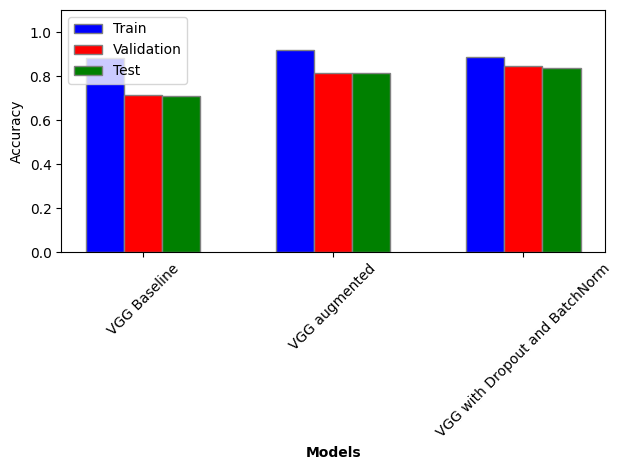

In [34]:
model_names = ["VGG Baseline", "VGG augmented", "VGG with Dropout and BatchNorm"]
train_accuracies = [baseline_vgg_train_accuracy, vgg_augmented_train_accuracy, vgg_dropout_batch_normalization_train_accuracy]
val_accuracies = [baseline_vgg_val_accuracy, vgg_augmented_val_accuracy, vgg_dropout_batch_normalization_val_accuracy]
test_accuracies = [baseline_vgg_test_accuracy, vgg_augmented_test_accuracy, vgg_dropout_batch_normalization_test_accuracy]

compare_models_accuracies(model_names, train_accuracies, val_accuracies, test_accuracies)

#### Top 3 class accuracies

313/313 [==============================] - 1s 3ms/step
[('frog', 0.952), ('automobile', 0.942), ('truck', 0.931)]


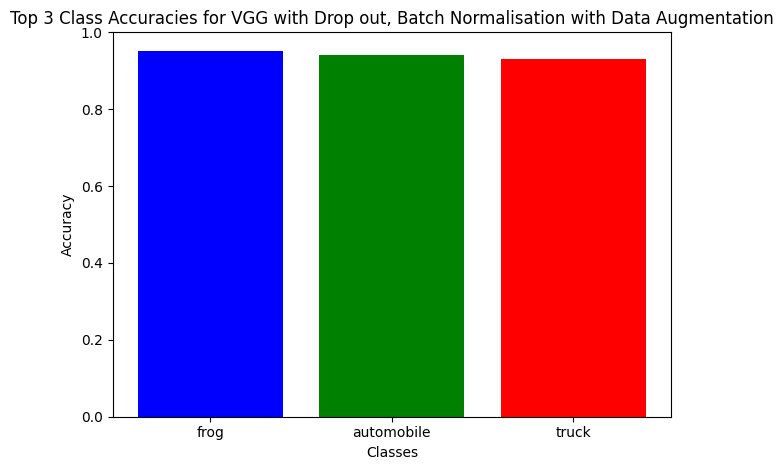

In [35]:
plot_top3_accuracies(vgg_dropout_batch_normalization_model, "VGG with Drop out, Batch Normalisation with Data Augmentation")